# Compare Implied Storage (Test Data) For Rule Based Model vs. LSTM Model 1

In [1]:
import os
print(f'Old working directory: {os.getcwd()}')
# change directory out of subdirectory 'experiments'
os.chdir('..')
print(f'Current working directory: {os.getcwd()}')

Old working directory: c:\Users\mattc\Documents\DL-reservoir-modeling\experiments
Current working directory: c:\Users\mattc\Documents\DL-reservoir-modeling


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from src.data.data_processing import *
from src.data.data_fetching import *
from src.models.model_zoo import *
from src.models.train_model import *
from src.models.analyze_lstm_cell import *
from src.data.implied_storage import get_implied_storage

from ssjrb_wrapper.model_wrapper import reservoir_model
from ssjrb_wrapper.util import read_historical_df
from ssjrb_wrapper.util import water_day
from ssjrb_wrapper.train_preprocess import train_medians

## Model 1

### Standardized Data

In [3]:
# Read in data, columns are [inflow, outflow, storage]
df = usbr_fetch_data(name='Shasta', vars=['inflow', 'outflow', 'storage'])
# Add day of the year (doy) as another column
df['doy'] = df.index.to_series().dt.dayofyear
# Select data window (beginning of 1944 to end of 2022)
df = df['1944-01-01':'2022-12-31'].copy()

# Run data processing pipeline
pipeline_std = processing_pipeline(train_frac=0.6, val_frac=0.2, test_frac=0.2, chunk_size=3*365, pad_value=-1)
# Train/val/test of shape (#chunks, chunksize, [inflow, outflow, storage, doy])
ts_train_std, ts_val_std, ts_test_std = pipeline_std.process_data(df) 

# Separate inputs(X) and targets (y)
# Select inflow and doy as input features
X_train_std, X_val_std, X_test_std = ts_train_std[:, :, [0, 3]], ts_val_std[:, :, [0, 3]], ts_test_std[:, :, [0, 3]]
# Select outflow as target feature
y_train_std, y_val_std, y_test_std = ts_train_std[:, :, [1]], ts_val_std[:, :, [1]], ts_test_std[:, :, [1]]

In [4]:
# Split df's
df_train, df_val, df_test = split_df_data(id="Shasta", left='1944-01-01', right='2022-12-31', data_splits=(0.6, 0.2, 0.2))

### Load Model 1 and Get Output Predictions 

In [5]:
# instantiate optimal model
input_size = 2
hidden_size1 = 30
hidden_size2 = 15
output_size = 1
dropout_prob = 0.3
num_layers = 1
torch.manual_seed(0)
model1 = LSTMModel1(input_size=input_size, hidden_size1=hidden_size1, 
                             hidden_size2=hidden_size2, output_size=output_size, num_layers=num_layers,
                             dropout_prob=dropout_prob)
# load saved model
model1.load_state_dict(torch.load('src/models/saved_models/model1a.pt', weights_only=True))
# turn model into evaluation model
model1.eval()

# Get predicted outflow states
from src.models.predict_model import *
outflow_hat_train = flatten_rm_pad(predict(model=model1, x=X_train_std),
                                   y_train_std)[0].detach().numpy()
outflow_hat_val = flatten_rm_pad(predict(model=model1, x=X_val_std),
                                   y_val_std)[0].detach().numpy()
outflow_hat_test = flatten_rm_pad(predict(model=model1, x=X_test_std),
                                   y_test_std)[0].detach().numpy()
assert outflow_hat_train.shape[0] == len(df_train)

### Unscale Outflow Predictions, Convert CFS to AF, Get Implied Storage

In [7]:
def unscale_series(x, train_data):
    """ 
    Unscale standardized input series based on training data statistics.
    Params: x - input numpy array, 
            train_data - training data used for scaling
    """
    return (x * train_data[~np.isnan(train_data)].std()) + train_data[~np.isnan(train_data)].mean()

In [8]:
# Undo scaling of predicted outflow, convert cfs to af
outflow_hat_test1 = unscale_series(outflow_hat_test, train_data=df_train.outflow) # in cfs, outflow_hat_test already has pads removed
outflow_hat_test1_af = outflow_hat_test1 * 86400 / 43559.9 # convert to acre-feet: (86400 seconds in a day, 43559.9 cfs in an acre-foot)
inflow_test_af = df_test.inflow * 86400 / 43559.9
inflow_test_af = pd.Series(inflow_test_af).fillna(df_train.inflow.mean() * 86400 / 43559.9).values # Fill NaN in observed inflow with training mean
assert outflow_hat_test1.shape[0] == len(df_test) & inflow_test_af.shape[0] == len(df_test)

# Calculate implied storage
implied_storage_test_model1 = get_implied_storage(inflow=inflow_test_af, 
                                                  outflow=outflow_hat_test1_af, 
                                                  initial_storage=df_val.storage.values[-1])

## Model 1-S

In [9]:
## Input data with storage included
X_train_sto, X_val_sto, X_test_sto = ts_train_std[:, :, [0, 2, 3]], ts_val_std[:, :, [0, 2, 3]], ts_test_std[:, :, [0, 2, 3]]

## Instantiate storage model
input_size = 3
hidden_size1 = 30
hidden_size2 = 15
output_size = 1
dropout_prob = 0.3
num_layers = 1
torch.manual_seed(0)
model1S = LSTMModel1_opt(input_size=input_size, hidden_size1=hidden_size1, hidden_size2=hidden_size2, output_size=output_size, 
                          num_layers=num_layers, dropout_prob=dropout_prob)


## Fit model
# Create PyTorch Dataset and Dataloader
dataset_train, dataset_val = (TensorDataset(X_train_sto, y_train_std), TensorDataset(X_val_sto, y_val_std))
dataloader_train, dataloader_val = (DataLoader(dataset_train, batch_size=1, shuffle=False), 
                                    DataLoader(dataset_val, batch_size=1, shuffle=False))
criterion = nn.MSELoss()
optimizer = optim.Adam(model1S.parameters(), lr=0.001)
# Run training loop
train_losses, val_losses = training_loop(model=model1S, criterion=criterion, optimizer=optimizer, 
                                        patience=10, dataloader_train=dataloader_train, 
                                        dataloader_val=dataloader_val, epochs=1000)

## Get predicted outflow states
outflow_hat_train1S = flatten_rm_pad(predict(model=model1S, x=X_train_sto),
                                   y_train_std)[0].detach().numpy()
outflow_hat_val1S = flatten_rm_pad(predict(model=model1S, x=X_val_sto),
                                   y_val_std)[0].detach().numpy()
outflow_hat_test1S = flatten_rm_pad(predict(model=model1S, x=X_test_sto),
                                   y_test_std)[0].detach().numpy()
assert outflow_hat_train1S.shape[0] == len(df_train)

## Undo scaling of predicted outflow, convert cfs to af
outflow_hat_test_model1S = unscale_series(outflow_hat_test1S, train_data=df_train.outflow) # in cfs, outflow_hat_test already has pads removed
outflow_hat_test_model1S_af = outflow_hat_test_model1S * 86400 / 43559.9 # convert to acre-feet: (86400 seconds in a day, 43559.9 cfs in an acre-foot)
assert outflow_hat_test_model1S.shape[0] == len(df_test)

# Calculate implied storage
implied_storage_test_model1S = get_implied_storage(inflow=inflow_test_af, 
                                                  outflow=outflow_hat_test_model1S_af, 
                                                  initial_storage=df_val.storage.values[-1])

Training epochs:   8%|▊         | 77/1000 [00:04<00:57, 16.12it/s]


## Model 3

In [10]:
## Instantiate model
input_size = 2
hidden_size1 = 35
hidden_size2 = 15
num_layers = 1
output_size = 1
dropout_prob = 0.3

torch.manual_seed(0)
model3 = LSTMModel3(input_size=input_size, hidden_size1=hidden_size1, 
                             hidden_size2=hidden_size2, output_size=output_size, num_layers=num_layers, dropout_prob=dropout_prob, initial_output=0, initial_implied_storage=0)

## Load saved model parameters
model3.load_state_dict(torch.load('src/models/saved_models/model3a.pt', weights_only=True))

## Get predicted outflow states
from src.models.predict_model import *
outflow_hat_train3 = flatten_rm_pad(predict(model=model3, x=X_train_std),
                                   y_train_std)[0].detach().numpy()
outflow_hat_val3 = flatten_rm_pad(predict(model=model3, x=X_val_std),
                                   y_val_std)[0].detach().numpy()
outflow_hat_test3 = flatten_rm_pad(predict(model=model3, x=X_test_std),
                                   y_test_std)[0].detach().numpy()
assert outflow_hat_train3.shape[0] == len(df_train)

## Undo scaling of predicted outflow, convert cfs to af
outflow_hat_test_model3 = unscale_series(outflow_hat_test3, train_data=df_train.outflow) # in cfs, outflow_hat_test already has pads removed
outflow_hat_test_model3_af = outflow_hat_test_model3 * 86400 / 43559.9 # convert to acre-feet: (86400 seconds in a day, 43559.9 cfs in an acre-foot)
assert outflow_hat_test_model3.shape[0] == len(df_test)

# Calculate implied storage
implied_storage_test_model3 = get_implied_storage(inflow=inflow_test_af, 
                                                  outflow=outflow_hat_test_model3_af, 
                                                  initial_storage=df_val.storage.values[-1])

## Model 4

In [11]:
## Instantiate model
input_size = 2
hidden_size = 50
output_size = 1
dropout_prob = 0.7
torch.manual_seed(0)
model4 = resRNN(input_size=input_size, hidden_size=hidden_size, output_size=output_size,
               dropout_prob=dropout_prob)
criterion = nn.MSELoss()
optimizer = optim.Adam(model4.parameters(), lr=0.001)

# load saved model
model4.load_state_dict(torch.load('src/models/saved_models/resRNN.pt', weights_only=True))

## Get predicted outflow states
from src.models.predict_model import *
outflow_hat_train4 = flatten_rm_pad(predict(model=model4, x=X_train_std),
                                   y_train_std)[0].detach().numpy()
outflow_hat_val4 = flatten_rm_pad(predict(model=model4, x=X_val_std),
                                   y_val_std)[0].detach().numpy()
outflow_hat_test4 = flatten_rm_pad(predict(model=model4, x=X_test_std),
                                   y_test_std)[0].detach().numpy()
assert outflow_hat_train4.shape[0] == len(df_train)

## Undo scaling of predicted outflow, convert cfs to af
outflow_hat_test_model4 = unscale_series(outflow_hat_test4, train_data=df_train.outflow) # in cfs, outflow_hat_test already has pads removed
outflow_hat_test_model4_af = outflow_hat_test_model4 * 86400 / 43559.9 # convert to acre-feet: (86400 seconds in a day, 43559.9 cfs in an acre-foot)
assert outflow_hat_test_model4.shape[0] == len(df_test)

# Calculate implied storage
implied_storage_test_model4 = get_implied_storage(inflow=inflow_test_af, 
                                                  outflow=outflow_hat_test_model4_af, 
                                                  initial_storage=df_val.storage.values[-1])

## Rule Based Model

### Fit Rule Based Model

In [12]:
def fit_one_reservoir(name, left, right = '2022-12-31'):
    """
    Fit SSJRB reservoir model to a single reservoir for USBR data

    Params:
    res_id -- str, Reservoir ID to fit model to
    left -- str (datelike), left window date to fetch data from
    right -- str (datelike), right window date to fetch data from

    Returns:
    model -- fitted SSJRB model
    r2_scores -- df of outflow r2 scores for train/val/test splits
    """

    ### DATA PROCESSING

    # Read in data, columns are [inflow, outflow, storage]
    df = usbr_fetch_data(name=name, vars=['inflow', 'outflow', 'storage'])
    # Select left-right window
    df = df[left:right].copy()

    # Rename columns to work with SSJRB wrapper
    df[f'{name}_inflow_cfs'] = df['inflow']
    df[f'{name}_outflow_cfs'] = df['outflow']
    df[f'{name}_storage_af'] = df['storage']

    # Add DOWY column
    doy_series = df.index.to_series().dt.dayofyear
    df['dowy'] = [water_day(i) for i in doy_series]

    # Train/val/test split
    df_train, df_val, df_test = train_val_test(df, train_frac=0.6, val_frac=0.2, test_frac=0.2)

    # Fill missing values with mean of training data
    train_mean = df_train.mean()
    df_train = df_train.fillna(train_mean)
    df_val = df_val.fillna(train_mean)
    df_test = df_test.fillna(train_mean)


    ### MODEL TRAINING

    # Capacity (take as max of training storage series)
    training_capacity = df_train[f'{name}_storage_af'].max() / 1000 # units = TAF
    capacity_dict = {name: training_capacity}

    # Instantiate model
    model_i = reservoir_model(reservoir_capacity = capacity_dict)
    # Fit with early stopping on validation data
    model_i.fit(df_train=df_train, df_val=df_val, patience=5)

    ### EVALUATE MODEL AND SAVE PARAMS

    # Get predictions from fitted model, evaluate r2 score
    df_hat_train, df_hat_val, df_hat_test = (model_i.predict(df = df_train),
                                            model_i.predict(df = df_val),
                                            model_i.predict(df = df_test))

    r2_scores = pd.DataFrame({'train': r2_score(df_train[f'{name}_outflow_cfs'], df_hat_train[f'{name}_outflow_cfs']),
                            'val': r2_score(df_val[f'{name}_outflow_cfs'], df_hat_val[f'{name}_outflow_cfs']),
                            'test': r2_score(df_test[f'{name}_outflow_cfs'], df_hat_test[f'{name}_outflow_cfs'])}, index=[name])

    # # Save model parameters
    # model_i.save_params(filepath='./results/saved_models/resops_ssjrb_reservoir', fileprefix=f'resops_ssjrb_model_{res_id}')

    return model_i, r2_scores

In [13]:
# Fit rule based model to Shasta reservoir
rule_model, rule_r2_scores = fit_one_reservoir(name='Shasta', left='1944-01-01', right='2022-12-31')
rule_r2_scores

Shasta: train score=14226278, val score: 18017592, NFE = 1659, Message: Early stopping triggered


,train,val,test
Shasta,0.685683,0.680901,0.655923


### Get Outflow Predictions, Convert CFS to AF, Get Implied Storage

In [14]:
# Rename columns to work with SSJRB wrapper
df[f'Shasta_inflow_cfs'] = df['inflow']
df[f'Shasta_outflow_cfs'] = df['outflow']
df[f'Shasta_storage_af'] = df['storage']

# Add DOWY column
doy_series = df.index.to_series().dt.dayofyear
df['dowy'] = [water_day(i) for i in doy_series]

# Train/val/test split
df_train_rule, df_val_rule, df_test_rule = train_val_test(df.copy(), train_frac=0.6, val_frac=0.2, test_frac=0.2)

# Fill missing values with mean of training data
train_mean = df_train_rule.mean()
df_train_rule = df_train_rule.fillna(train_mean)
df_val_rule = df_val_rule.fillna(train_mean)
df_test_rule = df_test_rule.fillna(train_mean)

# Get prediction from test data
outflow_hat_test_rule = rule_model.predict(df=df_test_rule)['Shasta_outflow_cfs'].values
outflow_hat_test_rule_af = outflow_hat_test_rule * 86400 / 43559.9  # convert to cfs to af
assert outflow_hat_test_rule_af.shape[0] == len(df_test)

# Calculate implied storage for rule based model
implied_storage_test_rule = get_implied_storage(inflow=inflow_test_af, 
                                                outflow=outflow_hat_test_rule_af, 
                                                initial_storage=df_val.storage.values[-1])

## Plot Implied vs Observed Storage for Both Models

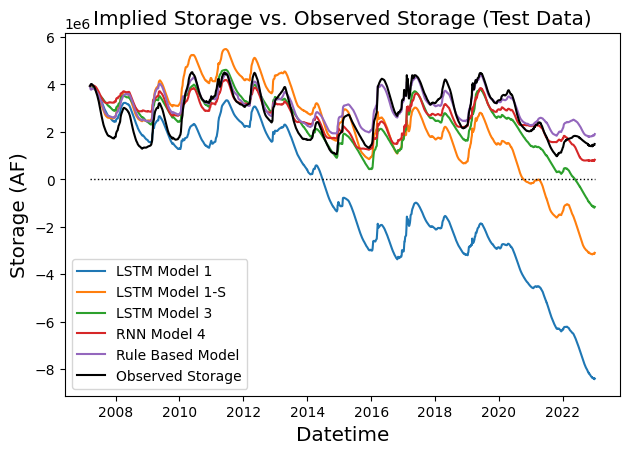

In [15]:
fig, ax = plt.subplots()
ax.plot(df_test.index, implied_storage_test_model1, label='LSTM Model 1')
ax.plot(df_test.index, implied_storage_test_model1S, label='LSTM Model 1-S')
ax.plot(df_test.index, implied_storage_test_model3, label='LSTM Model 3')
ax.plot(df_test.index, implied_storage_test_model4, label='RNN Model 4')
ax.plot(df_test.index, implied_storage_test_rule, label='Rule Based Model')
ax.plot(df_test.index, df_test.storage.values, color='black', linestyle="-", label='Observed Storage')

ax.hlines(y=0, xmin=df_test.index.min(), xmax=df_test.index.max(), color='k', linestyle=':', linewidth=1)

ax.set_title('Implied Storage vs. Observed Storage (Test Data)', size='x-large')
ax.set_xlabel('Datetime', size='x-large')
ax.set_ylabel('Storage (AF)', size='x-large')
ax.legend()
plt.tight_layout()
plt.savefig('report/drafting/8_15_2025/Figures/implied_storage_comparison.png', dpi=300)
plt.show()